In [1]:
import os
import copy
import numpy as np
import itertools
import matplotlib.pyplot as plt
import krippendorff
from endoanalysis.datasets import PointsDataset
from endoanalysis.agreement import OKSimilarity, compose_batch_relaibility_matrix
from endoanalysis.nucprop import NucleiPropagator

In [2]:
from endoanalysis.datasets import extract_images_and_labels_paths

In [3]:
images_list_file = "../data/Dataset/files_lists/Agreement/Explicit/Ptg1/images.txt"
labels_list_file = "../data/Dataset/files_lists/Agreement/Explicit/Ptg1/labels.txt"

In [4]:
ds  =PointsDataset(images_list_file, labels_list_file, keypoints_dtype=float)

In [5]:
ds.labels_paths[0]

'../data/Dataset/labels/Agreement/Explicit/Ptg1/1060.txt'

In [6]:
os.path.exists(ds.labels_paths[0])

True

In [7]:
from endoanalysis.keypoints import load_keypoints

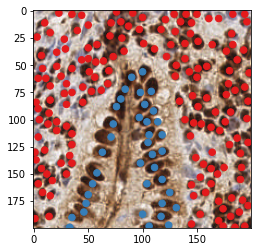

In [8]:
ds.visualize(2)

In [19]:
os.listdir(agreement_dir)

['Stud3', 'Ptg3', 'Stud2', 'Stud4', 'Stud1']

In [103]:
agreement_dir = "../data/Dataset/files_lists/Agreement/Hidden/Complete/"
experts = ['Ptg3', 'Stud1', 'Stud2', 'Stud3', 'Stud4']

datasets = {}
dataloaders = {}
datasets_lens = {}
keypoints  = {}
datasets = {}

for expert_name in experts:
    images_file_list = os.path.join(agreement_dir, expert_name, "images.txt")
    labels_file_list = os.path.join(agreement_dir, expert_name, "labels.txt")
    dataset = PointsDataset(
        images_file_list,
        labels_file_list,
        keypoints_dtype = float
    )
    datasets_lens[expert_name] = len(dataset)
    datasets[expert_name] = dataset
    
    keypoints[expert_name] = dataset.collate()["keypoints"]

    

In [104]:
datasets_lens_list = list(datasets_lens.values())
if len(np.unique(datasets_lens_list)) != 1:
    raise Exception("Some annotators have different numbe of images than the others")
else:
    num_images = datasets_lens_list[0]

In [105]:
similarity = OKSimilarity(scale=7.36)

In [106]:
experts = ['Ptg3', 'Stud1', 'Stud2', 'Stud3', 'Stud4']

In [107]:
relaibility_matrix = compose_batch_relaibility_matrix(
    keypoints,
    experts, 
    OKSimilarity(scale=7.36), 
    sim_thresh=0.5, 
    images_indexes=[0,1,2,3,4,5,6,7,8,9], 
    missings_as_classes=False, 
    class_agnostic=False
)

  0%|          | 0/10 [00:00<?, ?it/s]

Composing relaibility matrix


100%|██████████| 10/10 [01:16<00:00,  7.62s/it]


In [108]:
relaibility_matrix

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  1., ..., nan, nan, nan],
       [ 1.,  0.,  1., ..., nan, nan, nan]])

In [109]:
krippendorff.alpha(relaibility_matrix, level_of_measurement="nominal")

0.5125749941079134

In [110]:
base_experts = [  "Ptg3"]
for student in ['Stud1', 'Stud2', 'Stud3', 'Stud4']:
    experts = base_experts + [student]
    relaibility_matrix = compose_batch_relaibility_matrix(
        keypoints, 
        experts, 
        OKSimilarity(scale=7.36), 
        sim_thresh=0.5, 
        images_indexes=list(range(10)), 
        missings_as_classes=False, 
        class_agnostic=False
    )
    alpha = krippendorff.alpha(relaibility_matrix, level_of_measurement="nominal")
    print(student, alpha)

 60%|██████    | 6/10 [00:00<00:00, 39.09it/s]

Composing relaibility matrix


 60%|██████    | 6/10 [00:00<00:00, 37.45it/s]

Stud1 0.9483083677685951
Composing relaibility matrix


 50%|█████     | 5/10 [00:00<00:00, 47.48it/s]

Stud2 0.9831116049191039
Composing relaibility matrix


100%|██████████| 10/10 [00:00<00:00, 67.82it/s]

Stud3 0.9623219652053204
Composing relaibility matrix
Stud4 0.9845994254707948


In [111]:
experts = ['Ptg3', 'Stud1', 'Stud2', 'Stud3', 'Stud4']

In [112]:
num_images = 10
keypoints_nums = np.zeros((len(experts), num_images))

for expert_i, expert in enumerate(experts):
    keypoints_num_expert = [len(keypoints[expert].from_image(image_i)) for image_i in range(num_images)]
    keypoints_nums[expert_i] = np.array(keypoints_num_expert)


In [113]:
keypoints_nums

array([[122., 105., 161., 205., 180., 245., 131., 130., 165., 199.],
       [125., 102., 145., 182., 170., 223., 127., 124., 170., 156.],
       [111.,  95., 154., 182., 182., 261., 142., 154., 173., 179.],
       [134., 104., 157., 203., 183., 270., 141., 150., 198., 189.],
       [ 69.,  63.,  98., 102., 114., 147.,  89.,  83., 114., 106.]])

In [114]:
krippendorff.alpha(reliability_data=keypoints_nums, level_of_measurement="ordinal")

0.4780583177210933

In [115]:
num_images = 10
base_experts = [ "Ptg3"]
for student in ['Stud1', 'Stud2', 'Stud3', 'Stud4']:
    experts = base_experts + [student]
    
    keypoints_nums = np.zeros((len(experts), num_images))

    for expert_i, expert in enumerate(experts):
        keypoints_num_expert = [len(keypoints[expert].from_image(image_i)) for image_i in range(num_images)]
        keypoints_nums[expert_i] = np.array(keypoints_num_expert)
    alpha = krippendorff.alpha(reliability_data=keypoints_nums, level_of_measurement="ordinal")
    print(student, alpha)

Stud1 0.884913468773514
Stud2 0.9370481927710843
Stud3 0.9228571428571428
Stud4 -0.11869826937547034


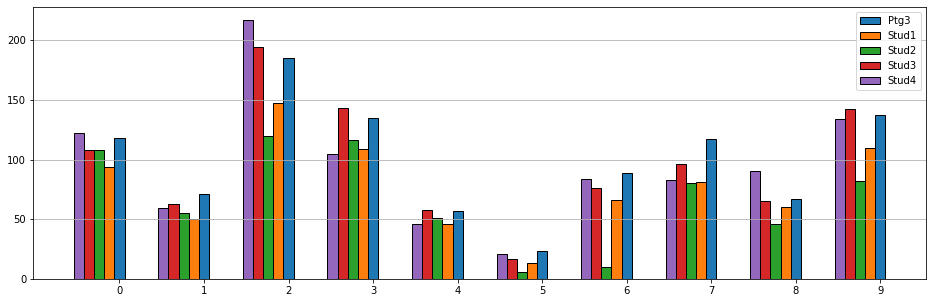

In [102]:
experts = ['Ptg3', 'Stud1', 'Stud2', 'Stud3', 'Stud4']


fig, ax = plt.subplots(1, figsize=(16,5))

keypoints_nums = np.zeros((len(experts), num_images))

for expert_i, expert in enumerate(experts):
    keypoints_num_expert = [len(keypoints[expert].from_image(image_i)) for image_i in range(num_images)]
    keypoints_nums[expert_i] = np.array(keypoints_num_expert)

x = np.arange(10)
for idx in range(len(experts)):
    ax.set_xticks(np.arange(10))
    ax.bar(x - idx*0.12 , keypoints_nums[idx], width=0.12 , align='center', edgecolor='black', zorder=1)
    ax.legend(experts)
    ax.grid(b=True,axis="y", zorder=2)
    